FOOTBALL DATA VISUALIZATION AND ANALYSIS DASHBOARD

#### Load the library

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle
import json


#### Read the dataset

In [10]:
path_WorldCup_events = '/mnt/d/HocTap2526/DoAn/DataSet/archive/events_World_Cup.csv'
path_WorldCup_matchs = '/mnt/d/HocTap2526/DoAn/DataSet/archive/matches_World_Cup.csv'
WorldCup_events = pd.read_csv(path_WorldCup_events)
WorldCup_matchs = pd.read_csv(path_WorldCup_matchs)

In [11]:
print(WorldCup_events.info())
print(WorldCup_matchs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101756 entries, 0 to 101755
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       101756 non-null  int64  
 1   subEventName  101584 non-null  object 
 2   tags          101756 non-null  object 
 3   playerId      101756 non-null  int64  
 4   positions     101756 non-null  object 
 5   matchId       101756 non-null  int64  
 6   eventName     101756 non-null  object 
 7   teamId        101756 non-null  int64  
 8   matchPeriod   101756 non-null  object 
 9   eventSec      101756 non-null  float64
 10  subEventId    101584 non-null  float64
 11  id            101756 non-null  int64  
 12  tagsList      95213 non-null   object 
 13  pos_orig_y    101756 non-null  int64  
 14  pos_orig_x    101756 non-null  int64  
 15  pos_dest_y    101756 non-null  int64  
 16  pos_dest_x    101756 non-null  int64  
dtypes: float64(2), int64(9), object(6)
memory usage:

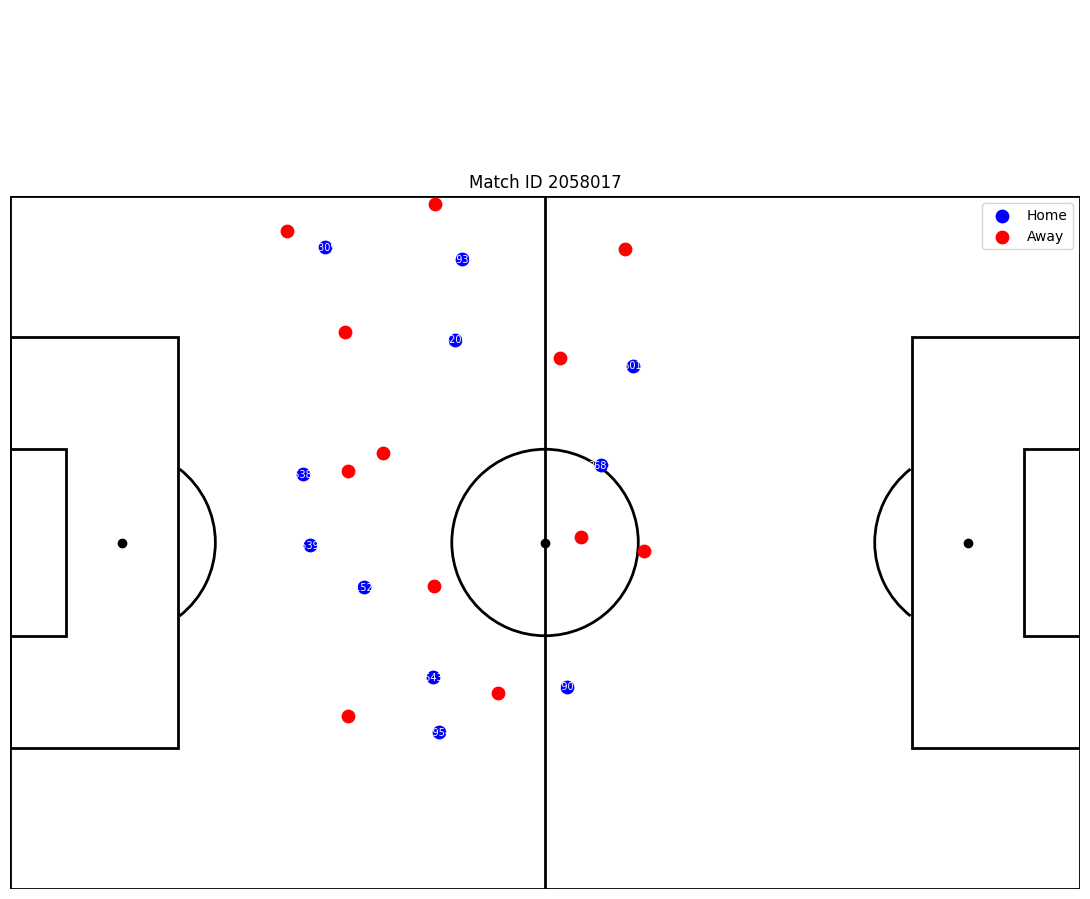

In [12]:
from pitch import plot_formation

match_id = WorldCup_matchs.iloc[0]['wyId']

match_events = WorldCup_events[WorldCup_events['matchId'] == match_id].copy()

match_events['positions'] = match_events['positions'].apply(
    lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) and x.startswith("[") else None
)

match_events = match_events.explode('positions').dropna(subset=['positions'])

match_events['x'] = match_events['positions'].apply(lambda p: p['x'])
match_events['y'] = match_events['positions'].apply(lambda p: p['y'])

positions = (
    match_events.groupby(['playerId', 'teamId'], as_index=False)[['x', 'y']].mean()
)

teams_data_str = WorldCup_matchs.iloc[0]['teamsData']
teams_data = json.loads(teams_data_str.replace("'", '"'))
team_map = {int(k): v['side'] for k, v in teams_data.items()}

positions['side'] = positions['teamId'].map(team_map)

plot_formation(positions, title=f'Match ID {match_id}')

### Mức độ ưu tiên tìm hiểu thông tin các file dữ liệu: tag2name -> enventId2Name -> event_WorldCup -> matches_WorldCup

In [13]:
from pitch import draw_pitch

print(WorldCup_events.columns)

WC_events_200 = WorldCup_events.head(200)

passes = WorldCup_events[WorldCup_events['eventName'] == 'Pass'].copy()

passes[['playerId', 'teamId', 'pos_orig_x', 'pos_orig_y', 'pos_dest_x', 'pos_dest_y']].head()

Index(['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id',
       'tagsList', 'pos_orig_y', 'pos_orig_x', 'pos_dest_y', 'pos_dest_x'],
      dtype='object')


,playerId,teamId,pos_orig_x,pos_orig_y,pos_dest_x,pos_dest_y
0,122671,16521,50,50,35,53
1,139393,16521,35,53,75,19
4,122847,16521,63,17,71,15
5,122832,16521,71,15,92,11
7,122847,16521,88,11,88,13


In [14]:
from gener_description import gener_action_Description

event_WC_path = '/mnt/d/HocTap2526/DoAn/DataSet/archive/events_World_Cup.csv'
eventId_path = '/mnt/d/HocTap2526/DoAn/DataSet/archive/eventid2name.csv'
tags_path = '/mnt/d/HocTap2526/DoAn/DataSet/archive/tags2name.csv'
output_path = 'event_descriptions.csv'

summary_df = gener_action_Description(event_WC_path, tags_path, output_path)
summary_df.head()

Đã lưu file vào thư mục: {output_path}


,subEventName,description,count
0,Simple pass,Accurate,40231.0
88,Touch,No specific tags,3517.0
17,Simple pass,Not accurate,2977.0
2,Air duel,"Won, Accurate",2420.0
13,Throw in,Accurate,2359.0


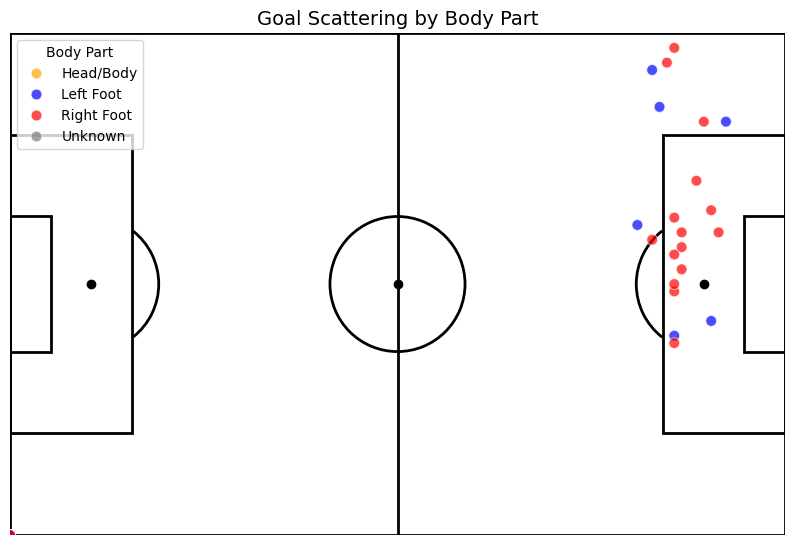

In [15]:
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pitch import draw_pitch

events_df_ = pd.read_csv(event_WC_path)
tags_df_ = pd.read_csv(tags_path)

tag_dict = dict(zip(tags_df_['Tag'], tags_df_["Label"]))

def parse_tags(tags_str):
    try:
        tags = ast.literal_eval(tags_str)
        return [tag_dict.get(t['id'], str(t['id'])) for t in tags if isinstance(t, dict) and 'id' in t]
    except Exception:
        return []


events_df_["tags_descriptions"] = events_df_["tags"].apply(parse_tags)

def extract_position_coords(pos_list):
    try:
        pos = ast.literal_eval(pos_list) if isinstance(pos_list, str) else pos_list
        if isinstance(pos, list) and len(pos) >=2:
            return pos[0]['x'], pos[0]['y'], pos[-1]['x'], pos[-1]['y']
    except Exception:
        pass
    return None, None, None, None

events_df_[['pos_orig_x', 'pos_orig_y', 'pos_dest_x', 'pos_dest_y']] = events_df_['positions'].apply(
    lambda x: pd.Series(extract_position_coords(x))
)

def is_goal_event(row):
    tags = row['tags_descriptions']
    if not any('goal' in t.lower() for t in tags):
        return False
    
    if any(ex in str(row['subEventName']).lower() for ex in ['goal kick', 'save', 'reflex', 'keeper', 'clearance']):
        return False
    
    if any(ex in str(row['eventName']).lower() for ex in ['goal kick', 'save', 'reflex', 'keeper', 'clearance']):
        return False
    
    if any('not accurate' in t.lower() for t in tags):
        return False
    
    return True

goal_events = events_df_[events_df_.apply(is_goal_event, axis=1)].copy()

def get_body_part(tags):
    tags_lower = [t.lower() for t in tags]
    if any('left' in t for t in tags_lower):
        return 'Left Foot'
    elif any('right' in t for t in tags_lower):
        return 'Right Foot'
    elif any('head/body' in t for t in tags_lower):
        return 'Head/Body'
    else:
        return 'Unknown'
    
goal_events['body_part'] = goal_events['tags_descriptions'].apply(get_body_part)

goal_events = goal_events.dropna(subset=["pos_dest_x", "pos_dest_y"])

fig, ax = plt.subplots(figsize=(10, 7))
ax = draw_pitch(ax=ax)

sns.scatterplot(
    data=goal_events,
    x="pos_dest_x",
    y="pos_dest_y",
    hue="body_part",
    s=60,
    alpha=0.7,
    palette={"Left Foot": "blue", "Right Foot": "red", "Head/Body": "orange", "Unknown": "gray"},
    ax=ax
)

plt.title("Goal Scattering by Body Part", fontsize=14)
plt.xlabel("X position (Destination)")
plt.ylabel("Y position (Destination)")
plt.legend(title="Body Part", loc="upper left")
plt.show()

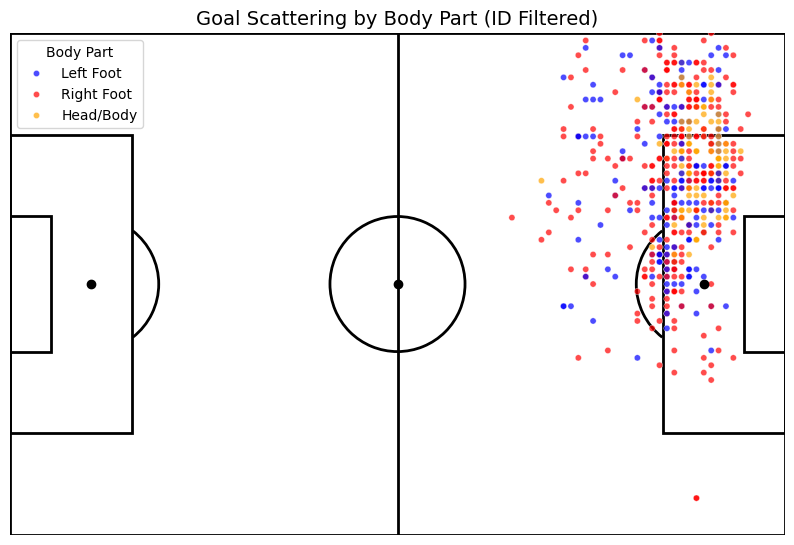

In [16]:
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pitch import draw_pitch 

Italy_path ='/mnt/d/HocTap2526/DoAn/DataSet/archive/events_Italy.csv'
events_df = pd.read_csv(Italy_path)
tags_df = pd.read_csv(tags_path)

tag_dict = dict(zip(tags_df['Tag'], tags_df["Label"]))

def parse_tags_and_ids(tags_str):
    tag_ids = []
    tag_labels = []
    try:
        tags = ast.literal_eval(tags_str) if isinstance(tags_str, str) else tags_str
        if not isinstance(tags, list):
            return [], []
        
        for t in tags:
            if isinstance(t, dict) and 'id' in t:
                tag_id = t['id']
                tag_ids.append(tag_id)
                tag_labels.append(tag_dict.get(tag_id, str(tag_id)))
                
    except Exception:
        pass
        
    return tag_ids, tag_labels

events_df[['tag_ids', 'tags_descriptions']] = events_df["tags"].apply(
    lambda x: pd.Series(parse_tags_and_ids(x))
)

def extract_position_coords(pos_list):
    try:
        pos = ast.literal_eval(pos_list) if isinstance(pos_list, str) else pos_list
        if isinstance(pos, list) and len(pos) >= 2:
            return pos[0]['x'], pos[0]['y'], pos[-1]['x'], pos[-1]['y']
    except Exception:
        pass
    return None, None, None, None

events_df[['pos_orig_x', 'pos_orig_y', 'pos_dest_x', 'pos_dest_y']] = events_df['positions'].apply(
    lambda x: pd.Series(extract_position_coords(x))
)

# ID Tag: 101: Goal, 102: own_goal, 1201: Not Accurate, 1801: Accurate
GOAL_ID = 101
OWN_GOAL_ID = 102
ACCURATE_ID = 1801
NOT_ACCURATE_ID = 1201

def is_goal_event(row):
    tag_ids = row['tag_ids']
    event_name = str(row['eventName']).lower()
    
    if GOAL_ID not in tag_ids or ACCURATE_ID not in tag_ids:
        return False
    
    if OWN_GOAL_ID in tag_ids:
        return False
    #if event_name not in ['shot', 'free kick', 'penalty']:
    #    return True
    if 'keeper' in event_name or 'reflex' in event_name or 'save' in event_name:
        return False
        
    return True

goal_events = events_df[events_df.apply(is_goal_event, axis=1)].copy()


LEFT_FOOT_ID = 401
RIGHT_FOOT_ID = 402
HEAD_BODY_ID = 403

def get_body_part(row):
    tag_ids = row['tag_ids']
    
    if LEFT_FOOT_ID in tag_ids:
        return 'Left Foot'
    elif RIGHT_FOOT_ID in tag_ids:
        return 'Right Foot'
    elif HEAD_BODY_ID in tag_ids:
        return 'Head/Body'
    else:
        if str(row['subEventName']).lower() == 'header':
            return 'Head/Body'
        return 'Unknown'
    
goal_events['body_part'] = goal_events.apply(get_body_part, axis=1)

goal_events = goal_events.dropna(subset=["pos_dest_x", "pos_dest_y"])

fig, ax = plt.subplots(figsize=(10, 7))
ax = draw_pitch(ax=ax)

goal_events['posit_x'] = goal_events.apply(lambda row: row['pos_dest_x'] if pd.notna(row['pos_dest_x']) and row['pos_dest_x'] != 0 else row['pos_orig_x'], axis=1)

goal_events['posit_y'] = goal_events.apply(lambda row: row['pos_dest_y'] if pd.notna(row['pos_dest_y']) and row['pos_dest_y'] != 0 else row['pos_orig_y'], axis= 1)

sns.scatterplot(
    data=goal_events,
    x="posit_x",
    y="posit_y",
    hue="body_part",
    s=20,
    alpha=0.7,
    palette={"Left Foot": "blue", "Right Foot": "red", "Head/Body": "orange", "Unknown": "gray"},
    ax=ax
)

plt.title("Goal Scattering by Body Part (ID Filtered)", fontsize=14)
plt.xlabel("X position (Destination)")
plt.ylabel("Y position (Destination)")
plt.legend(title="Body Part", loc="upper left")
plt.show()

In [1]:
import pandas as pd
import numpy as np


In [5]:
path_matches = "/mnt/d/HocTap2526/DoAn/DataSet/archive/matches_England.csv"

df_matches = pd.read_csv(path_matches)

pd.set_option('display.max_colwidth', None)

# In ra dòng đầu tiên của cột 'referees'
print(df_matches["referees"].head(1))

0    [{'refereeId': 385705, 'role': 'referee'}, {'refereeId': 385733, 'role': 'firstAssistant'}, {'refereeId': 385922, 'role': 'secondAssistant'}, {'refereeId': 388333, 'role': 'fourthOfficial'}]
Name: referees, dtype: object
